In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [2]:
dev = qml.device('lightning.qubit', wires=9)

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Data generation

As toy dataset we draw $N=120$ integers between $0$ and $16$ from a gaussian peak.

In [4]:
N = 120

In [5]:
data = np.random.normal(loc=7,scale=1.5, size=N).astype(int)
values, counts = np.unique(data, return_counts=True)

Pad values which were drawn $0$ times for plotting.

In [6]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

Lets look at our distribution

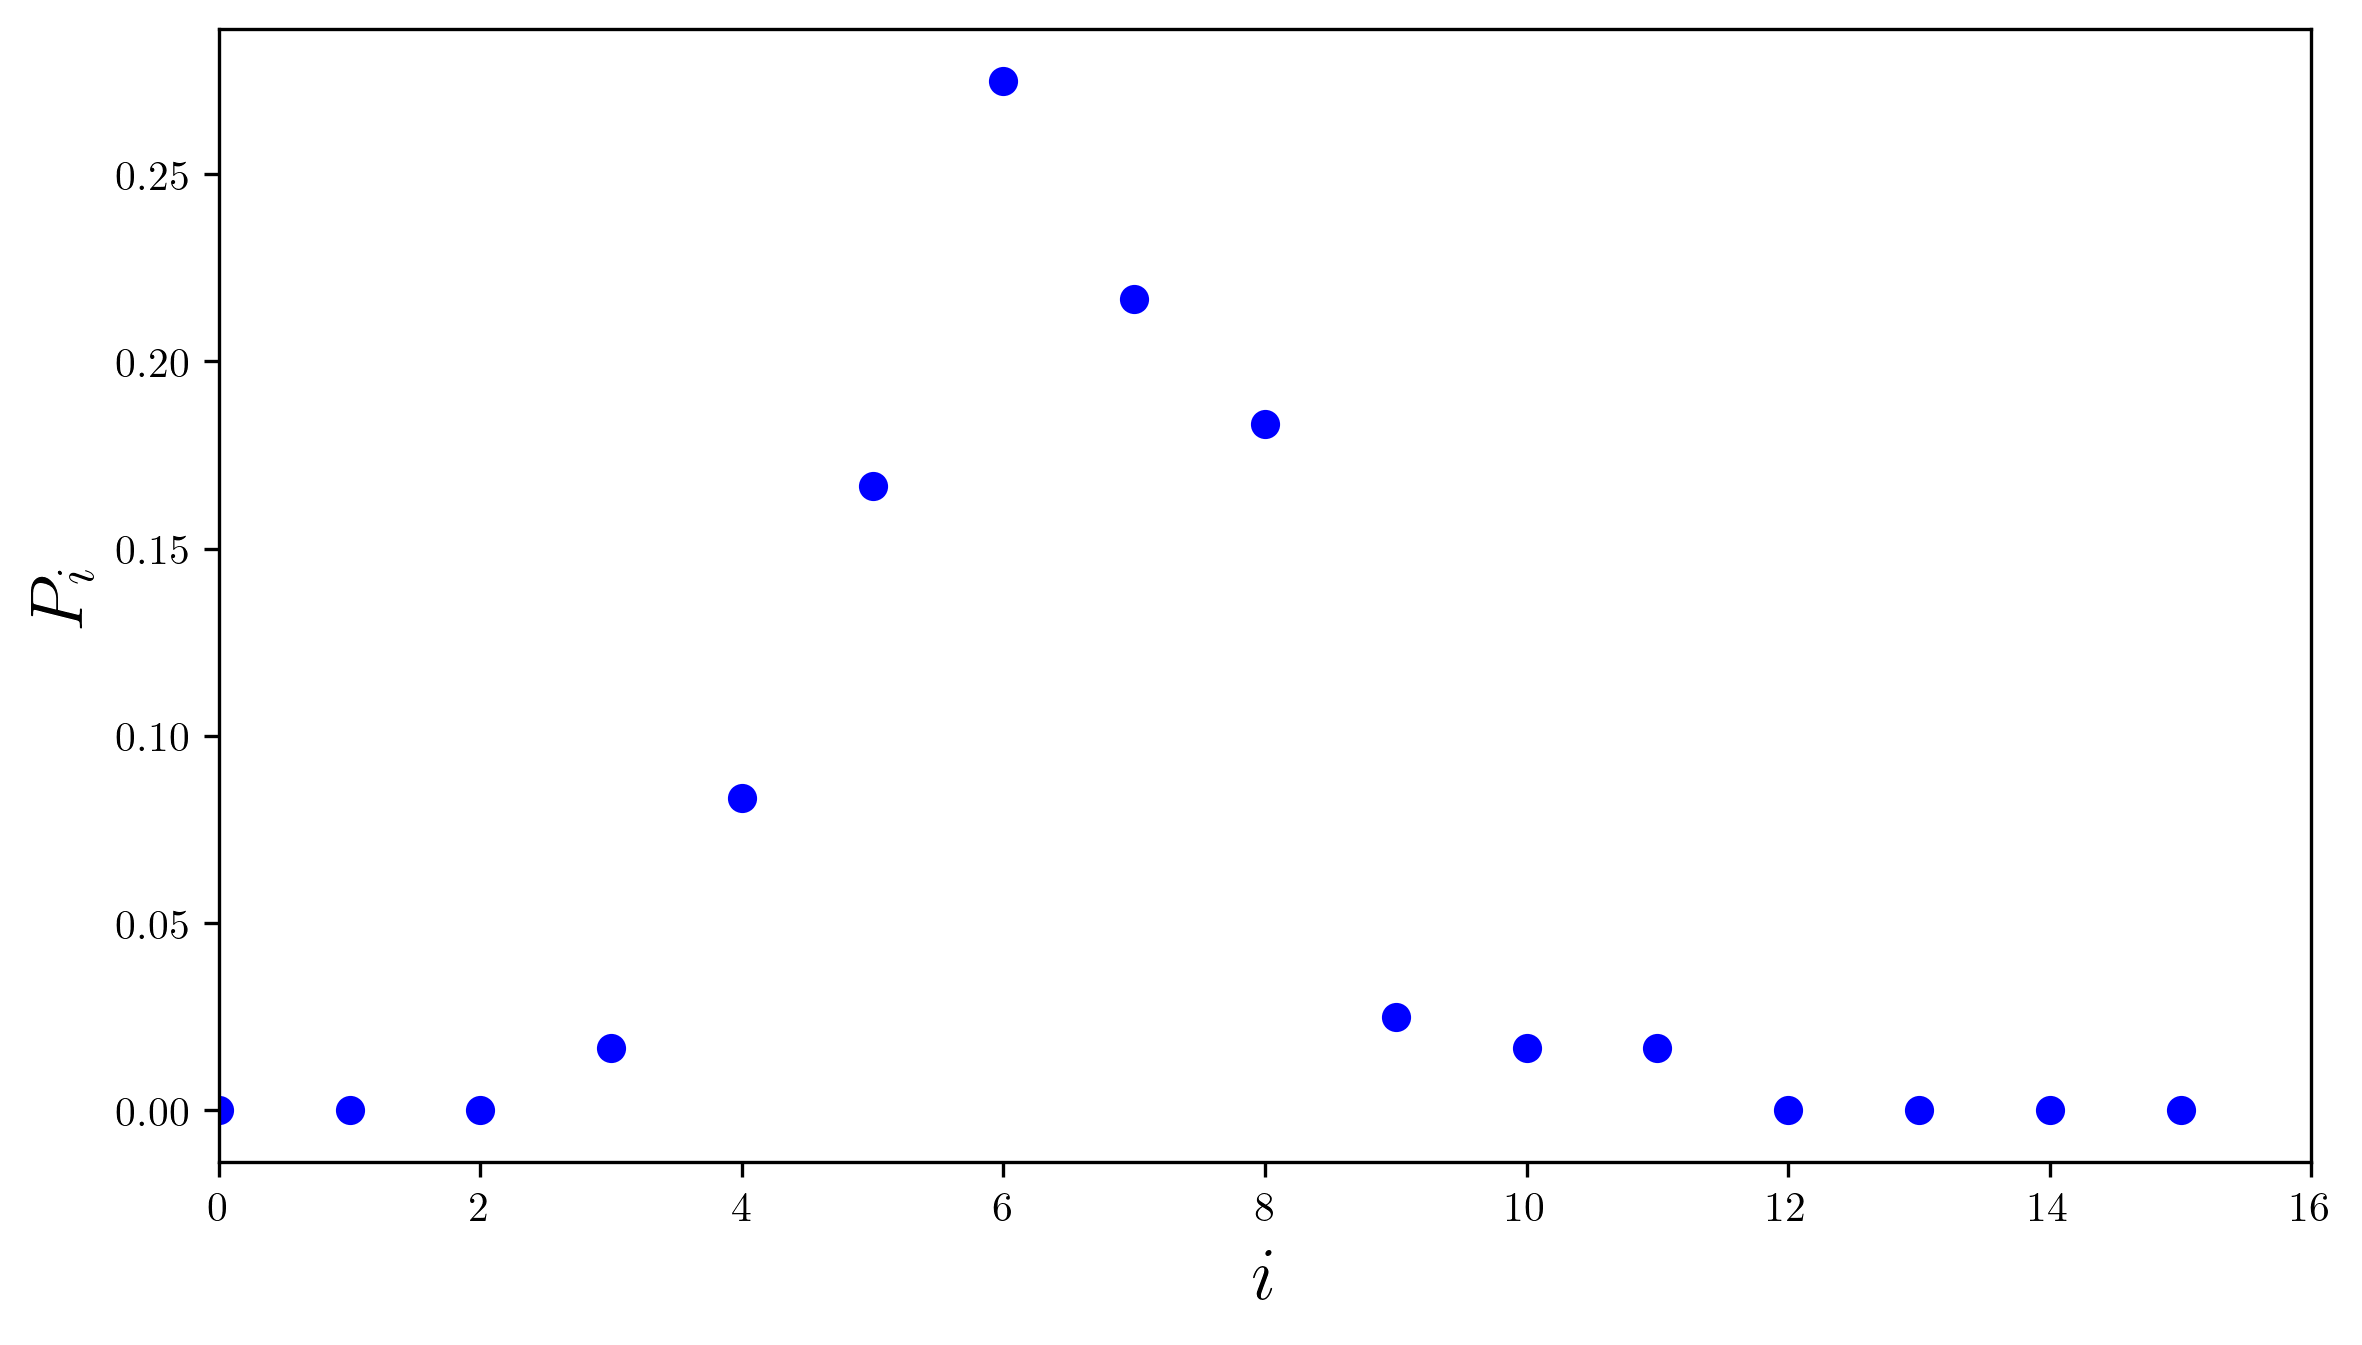

In [7]:
plt.figure(figsize=(9,5))
plt.plot(values,counts/N, 'b.', markersize=12)
plt.ylabel('$P_i$', fontsize=18)
plt.xlabel('$i$', fontsize=18)
plt.xlim(0,16)
plt.gcf().set_dpi(300)

To embed the data into a quantum basis, we convert the number into binary and build respective quantum states by applying $X$ gates to nonzero bits.

In [8]:
def num_circuit(num, wires):
    bin_str = format(num, '#06b')[2:]
    for i, c in enumerate(bin_str):
        if c == '1':
            qml.PauliX(wires=i+wires[0])

Lets look at an example circuit by plotting it:

In [9]:
devs = qml.device('lightning.qubit', wires=4, shots=10)

In [10]:
@qml.qnode(devs)
def circuit(num):
    num_circuit(num, [0,1,2,3])
    return qml.sample()

/tmp/ipykernel_1038374/2324509256.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


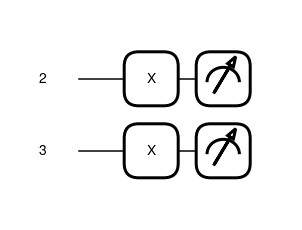

In [11]:
fig, ax = qml.draw_mpl(circuit)(3)
fig.show()

## Model

### Generator

We build the generator as a [Strongly Entangling Layer](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)

In [12]:
def generator(params, qbits):
    qml.StronglyEntanglingLayers(weights=params, wires=[qbits[0],qbits[1],qbits[2],qbits[3]])

Lets again look at an example generator circuit

In [13]:
@qml.qnode(dev)
def circuit2(params, wires):
    generator(params, wires)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_1038374/1974881317.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


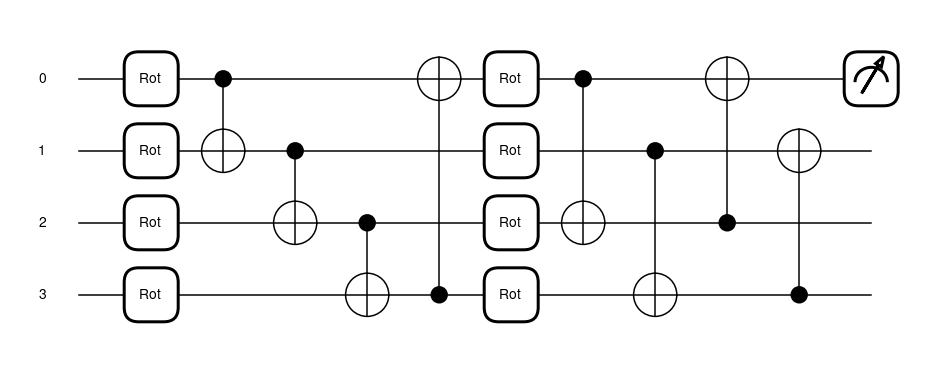

In [14]:
fig, ax = qml.draw_mpl(circuit2)(np.zeros(shape=(2,4,3)), [0,1,2,3])
fig.show()

### Gan circuit

The GAN is build from the real data in qubits $1-4$, the generator circuit in qubits $5-8$ and a SWAP test between the two states to measure the similarity.
The result of the SWAP test is read out from qubit $0$.

In [15]:
@qml.qnode(dev)
def training_circ(data, paramsg):
    # top 4 qbits real data
    num_circuit(data, [1,2,3,4])
    
    # bottom 4 qubits generator ansatz
    generator(paramsg, [5,6,7,8])
    
    # swap test
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0,1,5])
    qml.CSWAP(wires=[0,2,6])
    qml.CSWAP(wires=[0,3,7])
    qml.CSWAP(wires=[0,4,8])
    qml.Hadamard(wires=0)
    
    return qml.expval(qml.PauliZ(0))

Lets draw an example of the training circuit:

/tmp/ipykernel_1038374/2202411966.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


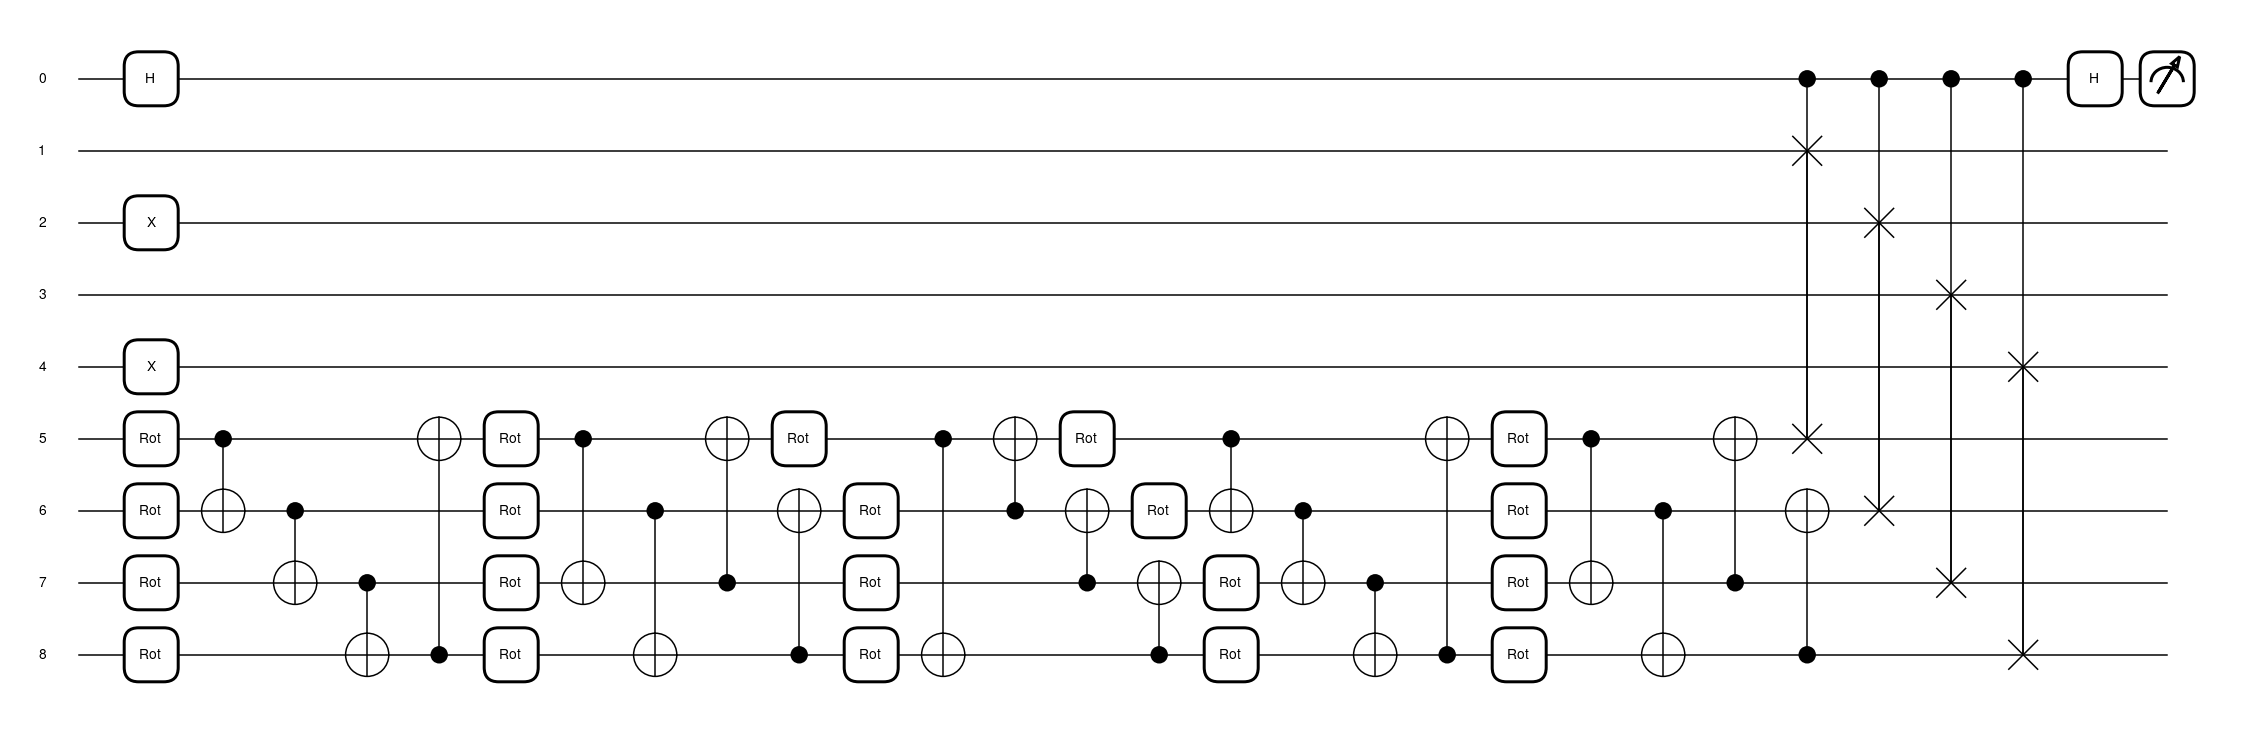

In [16]:
fig, ax = qml.draw_mpl(training_circ)(5, np.random.random(size=(5,4,3)))
fig.show()

## Training 

Training parameters:
1. Epochs
2. Batch size
3. Learning rate
4. Layers in the Strongly Entangling generator circuit

In [17]:
epochs = 40
batch_size=16
learning_rate=0.01
layers = 18

To train the circuit we first define the loss function.

It is given by
$$\mathcal{L}=-\log\big[\big|\big<\sigma|G(\Theta_g)\big>\big|^2\big]$$
where the fidelity is exatly the output of the swap test.

We also add a small regularization $\epsilon$ in the $\log$

In [18]:
def cost_batch(paramsg, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg) + reg
        loss += - np.log(f)
    return loss / len(batch)

We initialize the parameters of the generator and the optimizer

In [19]:
paramsg = np.random.uniform(0,np.pi, size=(layers,4,3), requires_grad=True)

In [20]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

To train we iterate over the data in batches

In [21]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In the training loop we save the loss.

Note that we define a the loss function with a lambda function for every batch of data to have only a single argument when passing it to the optimizer.

In [22]:
losshist = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        cost_fn = lambda p: cost_batch(p, Xbatch)
        paramsg = optg.step(cost_fn, paramsg)
        print(j, end="\r")

    loss = cost_batch(paramsg, data)
    
    losshist += [loss]
    
    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 1.93 | 
____
Epoch: 1 | Loss: 1.84 | 
____
Epoch: 2 | Loss: 1.84 | 
____
Epoch: 3 | Loss: 1.81 | 
____
Epoch: 4 | Loss: 1.81 | 
____
Epoch: 5 | Loss: 1.81 | 
____
Epoch: 6 | Loss: 1.8 | 
____
Epoch: 7 | Loss: 1.8 | 
____
Epoch: 8 | Loss: 1.8 | 
____
Epoch: 9 | Loss: 1.8 | 
____
Epoch: 10 | Loss: 1.8 | 
____
Epoch: 11 | Loss: 1.8 | 
____
Epoch: 12 | Loss: 1.8 | 
____
Epoch: 13 | Loss: 1.8 | 
____
Epoch: 14 | Loss: 1.8 | 
____
Epoch: 15 | Loss: 1.8 | 
____
Epoch: 16 | Loss: 1.8 | 
____
Epoch: 17 | Loss: 1.8 | 
____
Epoch: 18 | Loss: 1.8 | 
____
Epoch: 19 | Loss: 1.8 | 
____
Epoch: 20 | Loss: 1.8 | 
____
Epoch: 21 | Loss: 1.8 | 
____
Epoch: 22 | Loss: 1.8 | 
____
Epoch: 23 | Loss: 1.8 | 
____
Epoch: 24 | Loss: 1.8 | 
____
Epoch: 25 | Loss: 1.8 | 
____
Epoch: 26 | Loss: 1.8 | 
____
Epoch: 27 | Loss: 1.8 | 
____
Epoch: 28 | Loss: 1.8 | 
____
Epoch: 29 | Loss: 1.8 | 
____
Epoch: 30 | Loss: 1.8 | 
____
Epoch: 31 | Loss: 1.8 | 
____
Epoch: 32 | Loss: 1.8 | 
____
Epoch: 33 | Lo

## Evaluation

Lets check the training results:

The loss evolution during training:

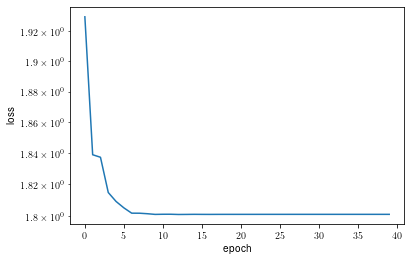

In [23]:
plt.plot(losshist)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')

Lets also check the distribution we get when sampling from the generator:

To do so we write a new qunode containing only the generator and sample from it.

In [24]:
sample_dev = qml.device('lightning.qubit', wires=4, shots = N)
@qml.qnode(sample_dev)
def sample_test():
    generator(paramsg, [0,1,2,3])
    return qml.sample()

To compare it with our generated data we convert convert a sample measurement from binary to integer and plot it 

In [25]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [26]:
valuestest, countstest = np.unique(testresult, return_counts=True)

In [27]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

We see a good agreement with the original distribution.

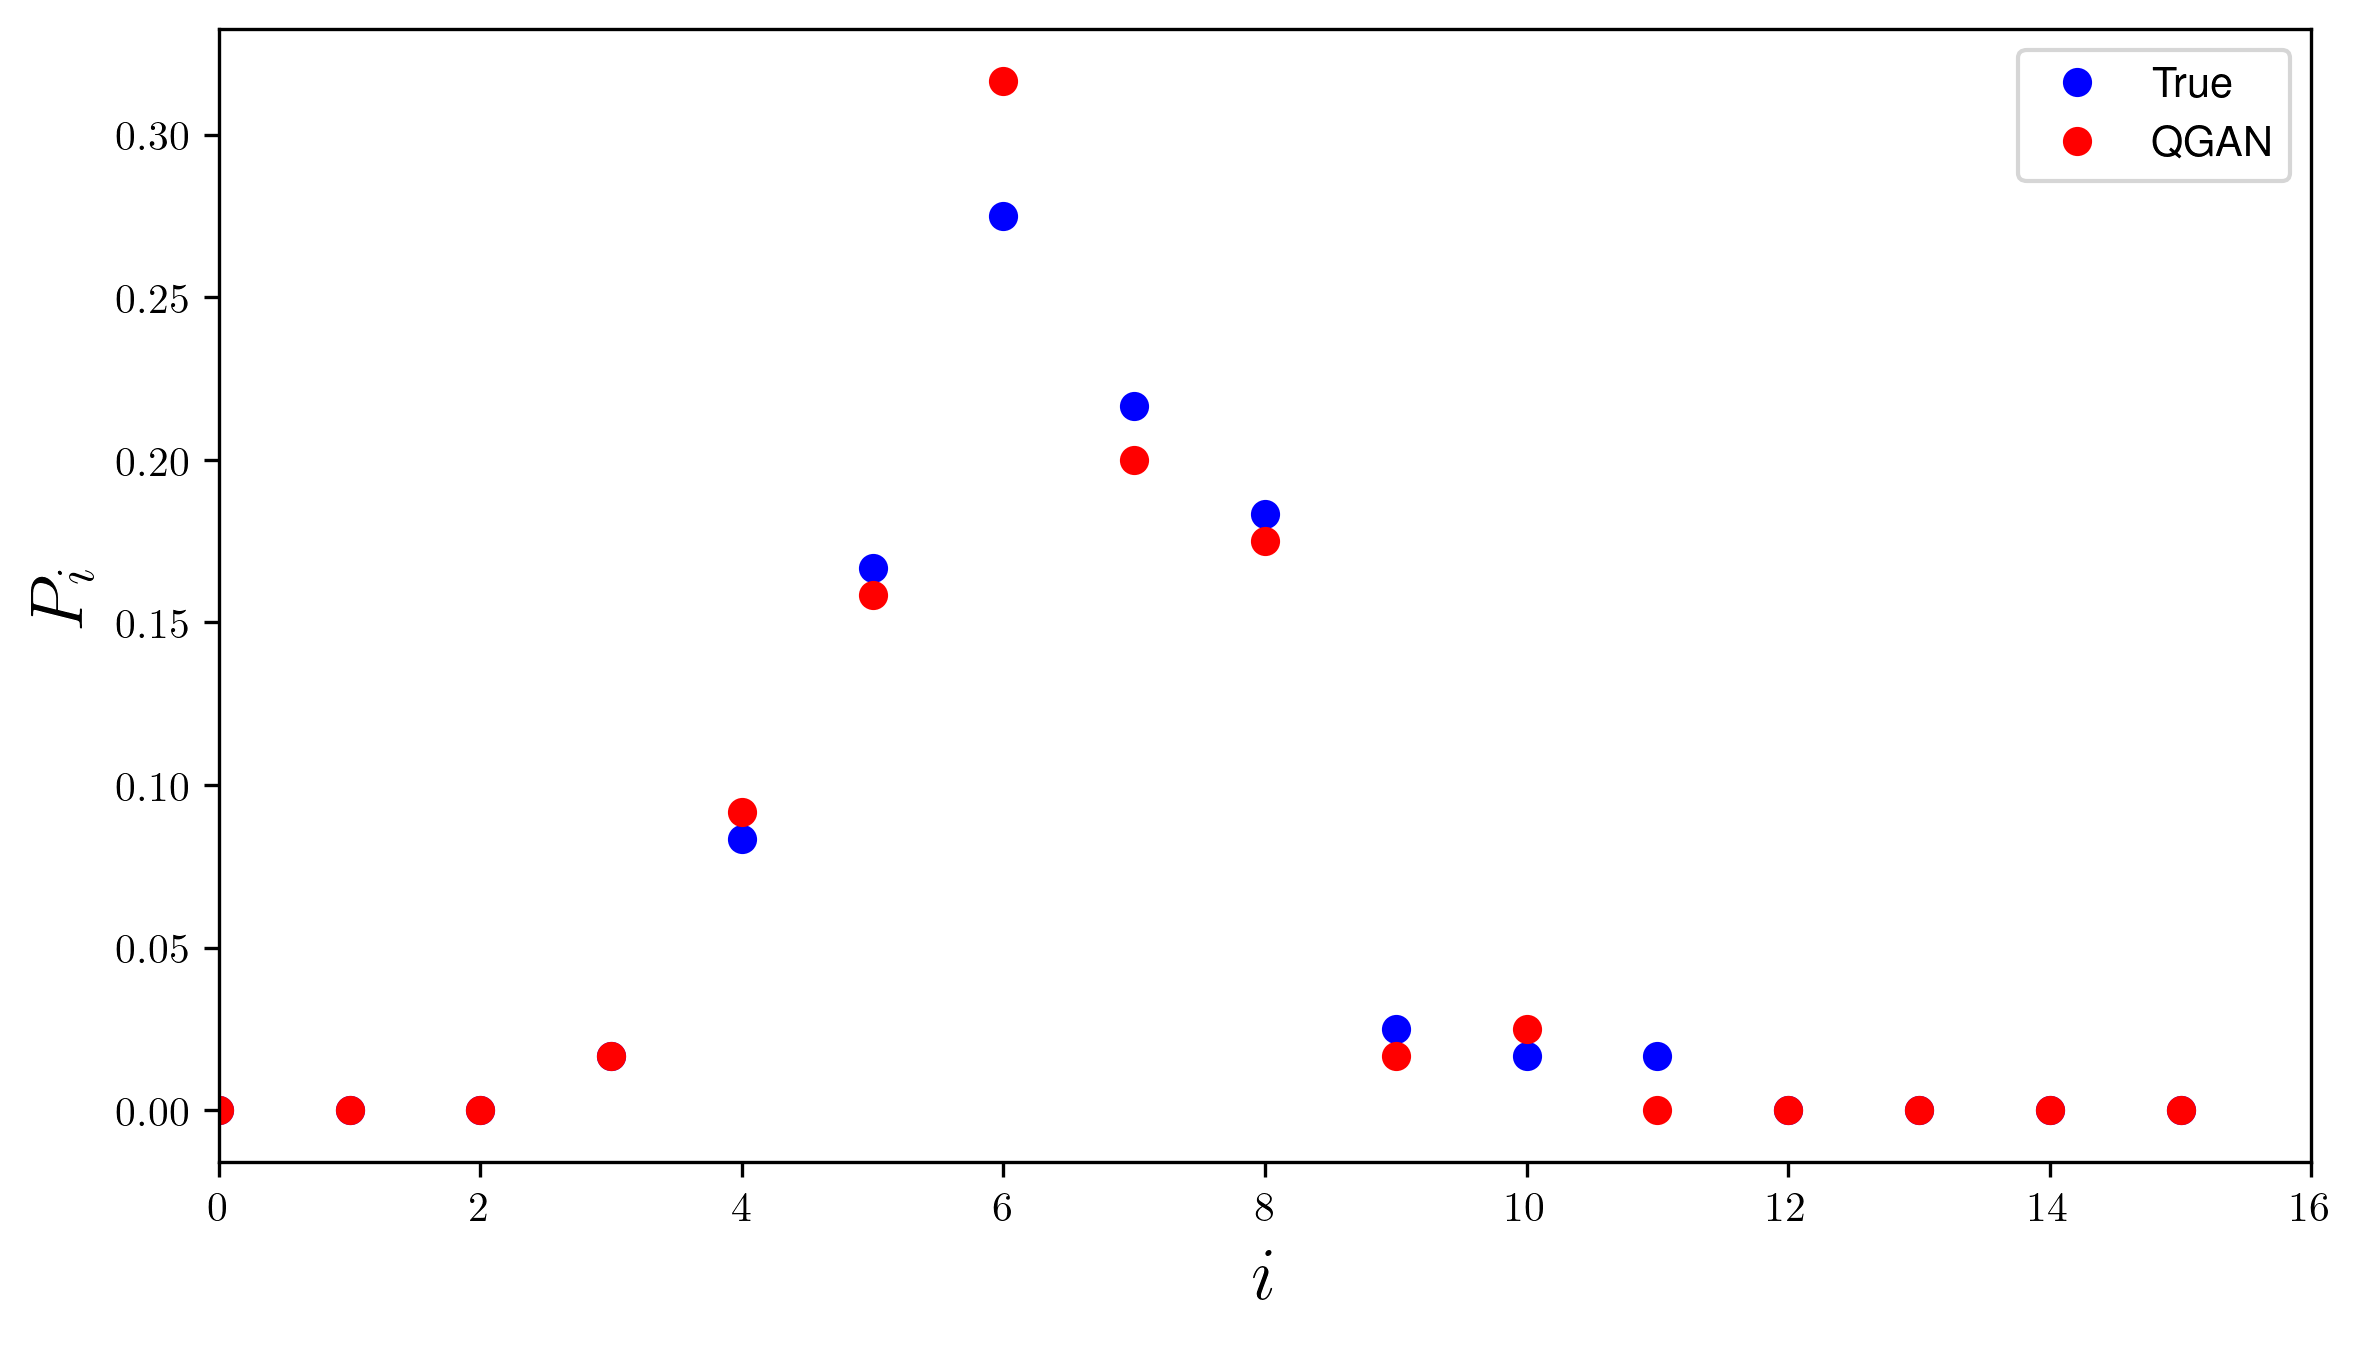

In [28]:
plt.figure(figsize=(9,5))
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="QGAN")
plt.ylabel('$P_i$', fontsize=18)
plt.xlabel('$i$', fontsize=18)
plt.legend()
plt.xlim(0,16)
plt.gcf().set_dpi(300)